In [18]:
import os,shutil
import numpy as np
import torch
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
data_folder = 'NewData'

# Not tested. hard code as below
def MovePicToFolder(meta_csv_file, image_col_name, type_col_name, pic_ext_name = 'jpg'):
    meta_data = pd.read_csv(meta_csv_file)
    
    filename_list = meta_data[image_col_name].values.tolist()
    folder_list = meta_data[type_col_name].values.tolist()
    
    #Create Folder if not exist
    df_group = meta_data.groupby(by = type_col_name)
    Cata_list = list(df_group.groups.keys())
    
    for i in range(len(Cata_list)):
    path = os.path.join(data_folder, Cata_list[i])
    if not os.path.exists(path):
        os.mkdir(path)
        
    # Move pictres to corresponding type folders
    # We can also run multi-thread to do such things, but run only one-time, so .....
    # Just like the Pytorch number_workers
    for i in range(len(filename_list)):
        filename = os.path.join(data_folder, filename_list[i] +'.'+ pic_ext_name)
        foldername = os.path.join(data_folder, folder_list[i])
        shutil.move(filename, foldername)
        
# MovePicToFolder('HAM10000_metadata.csv',)

In [23]:
meta_data = pd.read_csv('HAM10000_metadata.csv')

filename_list = meta_data['image_id'].values.tolist()
folder_list = meta_data['dx'].values.tolist()

df_group = meta_data.groupby(by = 'dx')
Cata_list = list(df_group.groups.keys())
Cata_list
data_folder = 'NewData'
for i in range(len(filename_list)):
    filename = os.path.join(data_folder, filename_list[i]+'.jpg')
    foldername = os.path.join(data_folder, folder_list[i])
    shutil.move(filename, foldername)
    

In [9]:
#Validate the folder classfiy correctly
meta_data = pd.read_csv('HAM10000_metadata.csv')
filename_list = meta_data['image_id'].values.tolist()
filetype_list = meta_data['dx'].values.tolist()
dict_type = dict(zip(filename_list, filetype_list))

df_group = meta_data.groupby(by = 'dx')
Cata_list = list(df_group.groups.keys())
data_folder = 'NewData'

total_corret = 0

for i in range(len(Cata_list)):
    SubFoldeNname = os.path.join(data_folder,Cata_list[i])
    print("SubFolder name is {}".format(SubFoldeNname))
    
    for sub_file in os.listdir(SubFoldeNname):
        sub_file = os.path.splitext(sub_file)[0]
        if dict_type[sub_file] == Cata_list[i]:
            total_corret += 1
        else:
            print('%s is not %s, correct type is %s',sub_file, SubFoldeNname, dict_type[sub_file])

print("Total correct number is:",total_corret)

SubFolder name is NewData\akiec
SubFolder name is NewData\bcc
SubFolder name is NewData\bkl
SubFolder name is NewData\df
SubFolder name is NewData\mel
SubFolder name is NewData\nv
SubFolder name is NewData\vasc
Total correct number is: 10015


10015

In [4]:
## Load and Transform our Data
# Orignal Data download from https://github.com/udacity/dermatologist-ai

#data_dir = 'd:\\Data\\'
#train_dir = os.path.join(data_dir, 'train')
#test_dir = os.path.join(data_dir, 'test')
#valid_dir = os.path.join(data_dir, 'valid')

# classes are folders in each directory with these names
#classes = ['melanoma', 'nevus', 'seborrheic_keratosis']


In [16]:
## Load and Transform our Data
# Orignal Data download from https://github.com/udacity/dermatologist-ai
data_dir = data_folder 

# classes are folders in each directory with these names
classes = Cata_list

valid_size = 0.2
train_size = 0.7
test_size = 0.1

In [13]:
data_dir

'NewData'

In [25]:
def CheckFileAccuracy(train_dir,filename = 'metadata.csv'):
    #metadata.csv contains the classfy info
    # We only need to verify 
    meta_data = pd.read_csv('metadata.csv')

    lista = meta_data['name'].values.tolist()
    listb = meta_data['meta.clinical.diagnosis'].values.tolist()

    dict_type = dict(zip(lista, listb))

    melanoma_correct = 0
    nevus_correct = 0
    seb_correct = 0
    
    train_dir_mela = os.path.join(train_dir,'melanoma')
    train_dir_nevus = os.path.join(train_dir,'nevus')
    train_dir_seb = os.path.join(train_dir,'seborrheic_keratosis')

    for file in os.listdir(train_dir_mela):
        file = os.path.splitext(file)[0]
        if dict_type[file] == 'melanoma':
            melanoma_correct += 1
        else:
            print('%s is not melanoma, correct type is %s',file, dict_type[file])

    for file in os.listdir(train_dir_nevus):
        file = os.path.splitext(file)[0]
        if dict_type[file] == 'nevus':
            nevus_correct += 1
        else:
            print('%s is not nevus, correct type is %s',file, dict_type[file])

    for file in os.listdir(train_dir_seb):
        file = os.path.splitext(file)[0]
        if dict_type[file] == 'seborrheic keratosis':
            seb_correct += 1
        else:
            print('%s is not seborrheic_keratosis, correct type is %s',file, dict_type[file])
    
    print('melanoma Accuracy %d / %d' %( melanoma_correct ,len(os.listdir(train_dir_mela))))
    print('nevus Accuracy %d / %d' %(nevus_correct ,len(os.listdir(train_dir_nevus))))
    print('seborrheic keratosis Accuracy %d / %d' %( seb_correct ,len(os.listdir(train_dir_seb))))
    
CheckFileAccuracy(train_dir)
CheckFileAccuracy(valid_dir)


In [33]:
#Randowm Resize 
data_transform = transforms.Compose([
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Resize(256),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(), 
        #transforms.Normalize(
        #    mean=[0.485, 0.456, 0.406],
        #    std=[0.229, 0.224, 0.225])
        ])

train_data = datasets.ImageFolder(data_folder, transform=data_transform)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)

# Train Split 
train_valid_split = int(np.floor((train_size+valid_size) * num_train)) 
valid_split = int(np.floor( train_size* num_train))

train_valid_idx, test_idx = indices[:train_valid_split], indices[train_valid_split:]
train_idx, valid_idx = indices[ :valid_split], indices[valid_split:train_valid_split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)


In [35]:
batch_size = 64
num_workers=5
train_data = datasets.ImageFolder(data_dir, transform=data_transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=test_sampler, num_workers=num_workers)

In [39]:
len(train_loader)

110

In [31]:

print(len(train_idx))
print(len(valid_idx))
print(len(test_idx))

print("--------------")
print(train_valid_split)
print(valid_split)

7010
2003
1002
--------------
9013
7010


In [29]:
valid_split

7010

In [4]:
# Deprecated
#Randowm Resize 
data_transform = transforms.Compose([
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Resize(256),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(), 
        #transforms.Normalize(
        #    mean=[0.485, 0.456, 0.406],
        #    std=[0.229, 0.224, 0.225])
        ])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=data_transform) 

# print out some data stats
print('Num training images: ', len(train_data))
print('Num valid images: ', len(valid_data))
print('Num test images: ', len(test_data))

Num training images:  3073
Num valid images:  144
Num test images:  600


In [5]:
batch_size = 64
num_workers=5

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True,drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True,drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True,drop_last=True)

In [40]:
def visual_data(data_loader,row_num,col_num):
    dataiter = iter(data_loader)
    images, labels = dataiter.next()
    images = images.numpy() # convert images to numpy for display

    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(row_num*col_num):
        ax = fig.add_subplot(col_num, row_num, idx+1, xticks=[], yticks=[])
        
        plt.imshow(np.transpose(images[idx], (1, 2, 0)))
        ax.set_title(classes[labels[idx]])

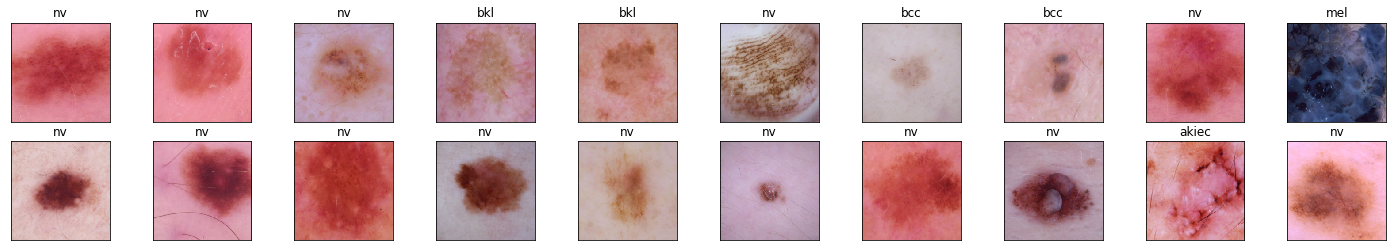

In [41]:
visual_data(train_loader,10,2)

In [43]:
resnet_50 = models.resnet50(pretrained=True)

#Freeze the parameters
for param in resnet_50.parameters():
    param.requires_grad_(False)
    
print(resnet_50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
#for m in resnet_50.modules():
#    if isinstance(m, nn.Linear):
#        m.weight.data =  nn.init.xavier_uniform_(m.weight.data,gain=nn.init.calculate_gain('relu')) 

In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [11]:
#classfier = nn.Sequential(nn.Linear(25088, 2048, bias=True),
#                          nn.ReLU(),
#                          nn.Dropout(0.2),
#                          nn.Linear(2048,112),
#                          nn.ReLU()
#                         )
full_connected_layers_new = nn.Sequential(nn.Linear(resnet_50.fc.in_features, 1024),
                          nn.BatchNorm1d(1024),
                          nn.ReLU(),
                          nn.Dropout(0.4),
                          nn.Linear(1024, 512),
                          nn.BatchNorm1d(512),
                          nn.ReLU(),
                          nn.Dropout(0.4),
                          nn.Linear(512, 256),
                          nn.BatchNorm1d(256),
                          nn.ReLU(),
                          nn.Dropout(0.4),            
                          nn.Linear(256, 128),
                          nn.BatchNorm1d(128),
                          nn.ReLU(),
                          nn.Dropout(0.4),            
                          nn.Linear(128, len(classes))) 


full_connected_layers = nn.Sequential(nn.Linear(resnet_50.fc.in_features, 1024),
                          nn.ReLU(),
                          nn.Dropout(0.2),
                          nn.Linear(1024, 512),
                          nn.ReLU(),
                          nn.Dropout(0.2),
                          nn.Linear(512, 256),
                          nn.ReLU(),
                          nn.Dropout(0.2),            
                          nn.Linear(256, 128),
                          nn.ReLU(),
                          nn.Dropout(0.2),            
                          nn.Linear(128, len(classes)) ) 

In [11]:
full_connected_layers_new = nn.Sequential(nn.Linear(resnet_50.fc.in_features, 512),
                          #nn.BatchNorm1d(512),
                          nn.ReLU(),
                          nn.Dropout(0.5),
                          nn.Linear(512, 128),
                          #nn.BatchNorm1d(128),
                          nn.ReLU(),
                          nn.Dropout(0.5),            
                          nn.Linear(128, len(classes))) 

In [12]:
                
resnet_50.fc= full_connected_layers_new#full_connected_layers

# if GPU is available, move the model to GPU
if train_on_gpu:
    resnet_50.cuda()

print(resnet_50.fc)

Sequential(
  (0): Linear(in_features=512, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=512, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=128, out_features=3, bias=True)
)


In [16]:
import torch.optim as optim
#Learning rate
lr = 0.0001
n_epochs = 20


# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (Adam) and learning rate = 0.0001
optimizer = optim.Adam(resnet_50.fc.parameters(), lr=lr)


In [17]:
train_loss_list = list()
valid_loss_list = list()

#If train and valid_loss less than np.inf  save the valid_loss
#Or shall we do some linear combination train_loss_min and valid_loss_min? such as α*train_loss_min + β*valid_loss_min

train_loss_min = np.inf


model_dir = 'D:\\Data\\'
model_name = 'model_resnet_50.pt'
model_name_new = 'model_resnet_50_new.pt'
save_path = model_dir + model_name
save_path_new = model_dir + model_name_new

In [20]:
resnet_50.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [18]:
def train_net(resnet_50,n_epochs, train_loss_list, valid_loss_list):
    valid_loss_min = np.inf
    train_loss_min = np.inf
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        ######################    
        # Training the model #
        ###################### 
        resnet_50.train()
        train_loss = 0.0
        
        # train on batches of data, assumes you already have train_loader
        for batch_i, (data, target) in enumerate(train_loader):
            
            if train_on_gpu: 
                data, target = data.cuda(), target.cuda()

            optimizer.zero_grad()
            
            output = resnet_50(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss = (train_loss * batch_i + loss.data) /  (batch_i + 1)
            train_loss_list.append(train_loss)
            print('Batch_i: {} \tTraining Loss: {:.6f} \t'.format(batch_i, train_loss,))
        ######################    
        # Valid the model #
        ###################### 
        resnet_50.eval()
        valid_loss = 0
        for batch_idx, (data, target) in enumerate(valid_loader):
            # move to GPU
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            
            output = resnet_50(data)
            loss = criterion(output, target)
            
            valid_loss = (valid_loss * batch_i + loss.data) /  (batch_i + 1)
            valid_loss_list.append(valid_loss)
        # print loss statistics
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## save the model if validation loss has decreased
        if train_loss < train_loss_min:
            train_loss_min = train_loss
            torch.save(resnet_50.state_dict(), save_path )

    print('Finished Training')


In [19]:
#torch.autograd.set_detect_anomaly(True)
n_epochs = 10
train_net(resnet_50,n_epochs,train_loss_list, valid_loss_list)

Batch_i: 0 	Training Loss: 1.177441 	
Batch_i: 1 	Training Loss: 1.170226 	
Batch_i: 2 	Training Loss: 1.135332 	
Batch_i: 3 	Training Loss: 1.134312 	
Batch_i: 4 	Training Loss: 1.127652 	
Batch_i: 5 	Training Loss: 1.122166 	
Batch_i: 6 	Training Loss: 1.114674 	
Batch_i: 7 	Training Loss: 1.106152 	
Batch_i: 8 	Training Loss: 1.103833 	
Batch_i: 9 	Training Loss: 1.095794 	
Batch_i: 10 	Training Loss: 1.094146 	
Batch_i: 11 	Training Loss: 1.090502 	
Batch_i: 12 	Training Loss: 1.084683 	
Batch_i: 13 	Training Loss: 1.078214 	
Batch_i: 14 	Training Loss: 1.076026 	
Batch_i: 15 	Training Loss: 1.073349 	
Batch_i: 16 	Training Loss: 1.068285 	
Batch_i: 17 	Training Loss: 1.064582 	
Batch_i: 18 	Training Loss: 1.061055 	
Batch_i: 19 	Training Loss: 1.057209 	
Batch_i: 20 	Training Loss: 1.052462 	
Batch_i: 21 	Training Loss: 1.051310 	
Batch_i: 22 	Training Loss: 1.049978 	
Batch_i: 23 	Training Loss: 1.047477 	
Batch_i: 24 	Training Loss: 1.044848 	
Batch_i: 25 	Training Loss: 1.04373

Batch_i: 14 	Training Loss: 0.786167 	
Batch_i: 15 	Training Loss: 0.783535 	
Batch_i: 16 	Training Loss: 0.789491 	
Batch_i: 17 	Training Loss: 0.789166 	
Batch_i: 18 	Training Loss: 0.788052 	
Batch_i: 19 	Training Loss: 0.785010 	
Batch_i: 20 	Training Loss: 0.778365 	
Batch_i: 21 	Training Loss: 0.777829 	
Batch_i: 22 	Training Loss: 0.776955 	
Batch_i: 23 	Training Loss: 0.777493 	
Batch_i: 24 	Training Loss: 0.774669 	
Batch_i: 25 	Training Loss: 0.772813 	
Batch_i: 26 	Training Loss: 0.771947 	
Batch_i: 27 	Training Loss: 0.774216 	
Batch_i: 28 	Training Loss: 0.774682 	
Batch_i: 29 	Training Loss: 0.780574 	
Batch_i: 30 	Training Loss: 0.778402 	
Batch_i: 31 	Training Loss: 0.782288 	
Batch_i: 32 	Training Loss: 0.777826 	
Batch_i: 33 	Training Loss: 0.775920 	
Batch_i: 34 	Training Loss: 0.772013 	
Batch_i: 35 	Training Loss: 0.772307 	
Batch_i: 36 	Training Loss: 0.768428 	
Batch_i: 37 	Training Loss: 0.767193 	
Batch_i: 38 	Training Loss: 0.767206 	
Batch_i: 39 	Training Los

Batch_i: 27 	Training Loss: 0.667635 	
Batch_i: 28 	Training Loss: 0.664425 	
Batch_i: 29 	Training Loss: 0.663910 	
Batch_i: 30 	Training Loss: 0.662911 	
Batch_i: 31 	Training Loss: 0.658738 	
Batch_i: 32 	Training Loss: 0.657931 	
Batch_i: 33 	Training Loss: 0.658395 	
Batch_i: 34 	Training Loss: 0.657327 	
Batch_i: 35 	Training Loss: 0.661379 	
Batch_i: 36 	Training Loss: 0.661834 	
Batch_i: 37 	Training Loss: 0.661031 	
Batch_i: 38 	Training Loss: 0.660908 	
Batch_i: 39 	Training Loss: 0.658550 	
Batch_i: 40 	Training Loss: 0.655770 	
Batch_i: 41 	Training Loss: 0.655533 	
Batch_i: 42 	Training Loss: 0.657805 	
Batch_i: 43 	Training Loss: 0.656393 	
Batch_i: 44 	Training Loss: 0.655503 	
Batch_i: 45 	Training Loss: 0.656146 	
Batch_i: 46 	Training Loss: 0.656729 	
Batch_i: 47 	Training Loss: 0.656768 	
Epoch: 8 	Training Loss: 0.656768 	Validation Loss: 0.029888
Batch_i: 0 	Training Loss: 0.478936 	
Batch_i: 1 	Training Loss: 0.543151 	
Batch_i: 2 	Training Loss: 0.546176 	
Batch_

In [21]:
test_loss = 0.0
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))

In [19]:
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    print("target len is",len(target))
    output = resnet_50(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)   
    
    print("pred is ",pred)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    print("correct is ",correct)
    break
    

target len is 64
pred is  tensor([0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 1, 2, 0, 0, 1, 2, 0, 0,
        0, 2, 0, 2, 1, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 2, 0, 1, 1], device='cuda:0')
correct is  [False  True  True  True  True False False False False False False  True
  True  True False False  True False False  True  True False False False
  True False False False  True False  True  True  True False False False
  True False  True False  True  True  True  True  True  True False False
  True False False False False False False  True  True False False  True
  True False  True  True]


0.765625

In [22]:
for batch_idx,(data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = resnet_50(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)   
    
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    
    for i in range(len(data)):   
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))
        
for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

    

Test Loss: 0.799040

Test Accuracy of melanoma: 42% (46/109)
Test Accuracy of nevus: 66% (253/381)
Test Accuracy of seborrheic_keratosis: 59% (51/86)

Test Accuracy (Overall): 60% (350/576)
